In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import inspect
import time
import pickle

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

from torchbeast.monobeast import create_env, AtariNet
from torchbeast.resnet_monobeast import ResNet
from torchbeast.core import environment

In [19]:
model_base_path = "../../models"
models = [
    ("Carnival", ["CarnivalNoFrameskip-v4"]),
    ("AirRaid", ["AirRaidNoFrameskip-v4"]),
    ("DemonAttack", ["DemonAttackNoFrameskip-v4"]),
    ("NameThisGame", ["NameThisGameNoFrameskip-v4"]),
    ("Pong", ["PongNoFrameskip-v4"]),
    ("SpaceInvaders", ["SpaceInvadersNoFrameskip-v4"]),
    ("MultiTask", [
        "CarnivalNoFrameskip-v4", 
        "AirRaidNoFrameskip-v4", 
        "DemonAttackNoFrameskip-v4", 
        "NameThisGameNoFrameskip-v4", 
        "PongNoFrameskip-v4", 
        "SpaceInvadersNoFrameskip-v4"
    ]),
    ("MultiTaskPopart", [
        "CarnivalNoFrameskip-v4", 
        "AirRaidNoFrameskip-v4", 
        "DemonAttackNoFrameskip-v4", 
        "NameThisGameNoFrameskip-v4", 
        "PongNoFrameskip-v4", 
        "SpaceInvadersNoFrameskip-v4"
    ])
]
ACTION_MEANING = {
    0: "NOOP",
    1: "FIRE",
    2: "UP",
    3: "RIGHT",
    4: "LEFT",
    5: "DOWN",
    6: "UPRIGHT",
    7: "UPLEFT",
    8: "DOWNRIGHT",
    9: "DOWNLEFT",
    10: "UPFIRE",
    11: "RIGHTFIRE",
    12: "LEFTFIRE",
    13: "DOWNFIRE",
    14: "UPRIGHTFIRE",
    15: "UPLEFTFIRE",
    16: "DOWNRIGHTFIRE",
    17: "DOWNLEFTFIRE",
}

generator = np.random.default_rng(42)
seeds = generator.choice(1000, size=10, replace=False).tolist()

In [23]:
data = []
for model_directory, environments in models:
    checkpoints = []
    for checkpoint in os.listdir(os.path.join(model_base_path, model_directory, "intermediate")):
        if not checkpoint.endswith(".tar"):
            continue
        checkpoint_n = int(re.search(r'\d+', checkpoint).group())
        checkpoints.append((checkpoint_n, checkpoint))
    checkpoints.sort()
    
    n_checkpoints = len(checkpoints)
    selected_models = [
        checkpoints[0],
        checkpoints[n_checkpoints // 3],
        checkpoints[n_checkpoints // 3 * 2],
        checkpoints[-1]
    ]
    
    for env_name in environments:
        env_actions = []
        for iteration_count, checkpoint_file in selected_models:
            start_time = time.time()
            checkpoint = torch.load(os.path.join(model_base_path, model_directory, "intermediate", checkpoint_file), map_location="cpu")
            if "baseline.mu" not in checkpoint["model_state_dict"]:
                checkpoint["model_state_dict"]["baseline.mu"] = torch.zeros(1)
                checkpoint["model_state_dict"]["baseline.sigma"] = torch.ones(1)
                num_tasks = 1
            else:
                num_tasks = checkpoint["model_state_dict"]["baseline.mu"].shape[0]
            num_actions = checkpoint["model_state_dict"]["policy.weight"].shape[0]

            model = ResNet(observation_shape=None,
                                num_actions=num_actions,
                                num_tasks=num_tasks,
                                use_lstm=False,
                                use_popart=True,
                                reward_clipping="abs_one")
            model.eval()
            model.load_state_dict(checkpoint["model_state_dict"])
            
            for random_seed in seeds:
                gym_env = create_env(env_name)
                gym_env.seed(random_seed)
                env = environment.Environment(gym_env)

                observation = env.initial()
                actions = []
                done = False
                with torch.no_grad():
                    while not done:
                        agent_outputs, state = model(observation)
                        action = agent_outputs["action"]
                        actions.append(action.item())
                        observation = env.step(action)
                        done = observation["done"]
            
            actions = np.array(actions)
            counts = []
            possible_actions = list(range(gym_env.action_space.n))
            for i in possible_actions:
                counts.append((actions == i).sum())
            
            env_actions.append((iteration_count, [c / actions.shape[0] * 100 for c in counts]))
            
            print(f"{model_directory}, {env_name}, {iteration_count} done in {(time.time() - start_time) / 60:.1f} minutes")
        data.append((model_directory, env_name, env_actions))

Carnival, CarnivalNoFrameskip-v4, 1013760 done in 0.9 minutes
Carnival, CarnivalNoFrameskip-v4, 17213440 done in 1.4 minutes
Carnival, CarnivalNoFrameskip-v4, 33354880 done in 0.3 minutes
Carnival, CarnivalNoFrameskip-v4, 50002560 done in 0.3 minutes
AirRaid, AirRaidNoFrameskip-v4, 1005440 done in 2.4 minutes
AirRaid, AirRaidNoFrameskip-v4, 17046400 done in 2.4 minutes
AirRaid, AirRaidNoFrameskip-v4, 33214080 done in 2.3 minutes
AirRaid, AirRaidNoFrameskip-v4, 50009600 done in 2.4 minutes
DemonAttack, DemonAttackNoFrameskip-v4, 1013760 done in 1.1 minutes
DemonAttack, DemonAttackNoFrameskip-v4, 17180160 done in 1.1 minutes
DemonAttack, DemonAttackNoFrameskip-v4, 33349120 done in 2.1 minutes
DemonAttack, DemonAttackNoFrameskip-v4, 50001280 done in 6.0 minutes
NameThisGame, NameThisGameNoFrameskip-v4, 1000960 done in 1.1 minutes
NameThisGame, NameThisGameNoFrameskip-v4, 17095040 done in 1.4 minutes
NameThisGame, NameThisGameNoFrameskip-v4, 33324800 done in 3.0 minutes
NameThisGame, NameT

In [25]:
pickle.dump(data, open( "10_games_data.pkl", "wb" ) )

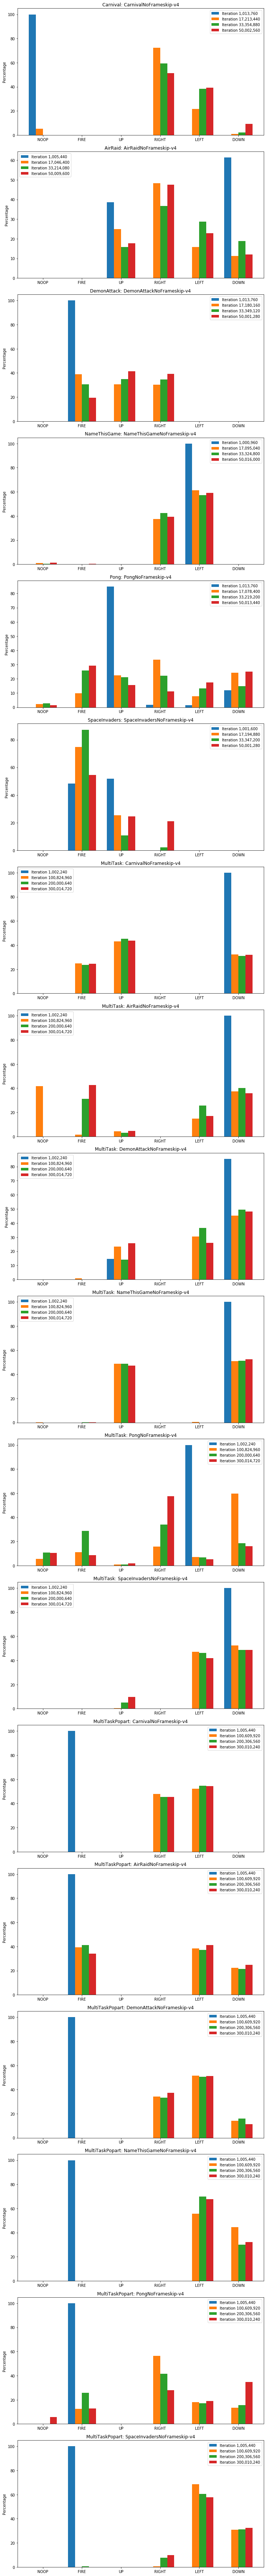

In [26]:
fig, axs = plt.subplots(len(data), figsize=(10, 96))
for i, (model_name, env_name, env_actions) in enumerate(data):
    width = 0.18
    x = np.arange(6)
    rects = []
    for j, (iterations, counts) in enumerate(env_actions):
        rect = axs[i].bar(x - 3 * width / 2 + j * width, counts, width, label=f'Iteration {iterations:,}')
        rects.append(rect)
    
    axs[i].set_xticks(x)
    axs[i].set_xticklabels([ACTION_MEANING[k] for k in range(6)])
    axs[i].set_ylabel('Percentage')
    axs[i].set_title(f'{model_name}: {env_name}')
    axs[i].legend()

fig.tight_layout()
plt.savefig("action_distributions.png")